<a href="https://colab.research.google.com/github/abjodas/GP-ENSO/blob/main/GPENSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
from bokeh.io import output_notebook
from bokeh.models import BoxAnnotation, Label, Legend, Span
from bokeh.palettes import brewer
from bokeh.plotting import figure, show
from scipy.signal import savgol_filter

output_notebook()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [ ]:
df = pd.read_csv('nino34.long.anom.csv')
df.columns = ['Date', 'NINA34']
df.head()

,Date,NINA34
0,1870-01-01,-1.00
1,1870-02-01,-1.20
2,1870-03-01,-0.83
3,1870-04-01,-0.81
4,1870-05-01,-1.27


In [ ]:
df['NINA34'] = df['NINA34'].replace(-9999, np.nan)
df['NINA34'].isna().sum()

np.int64(4)

In [ ]:
df = df.dropna()
df['NINA34'].isna().sum()

np.int64(0)

In [ ]:
df['NINA34_smoothed'] = df['NINA34'].rolling(window=3, center=True).mean()
# df['NINA12_smoothed'] = savgol_filter(
#     df['NINA12'],
#     window_length=11,
#     polyorder=3
# )
# df['NINA12_smoothed'] = df['NINA12'].ewm(span=12).mean()
df = df.dropna(subset=['NINA34_smoothed'])

In [ ]:
df.index = pd.to_datetime(df.Date)
df.head()

,Date,NINA34,t,NINA34_smoothed
Date,,,,
1870-08-01,1870-08-01,-0.88,0.580822,-0.816667
1870-09-01,1870-09-01,-0.53,0.665753,-0.776667
1870-10-01,1870-10-01,-0.92,0.747945,-0.746667
1870-11-01,1870-11-01,-0.79,0.832877,-0.833333
1870-12-01,1870-12-01,-0.79,0.915068,-0.610000


In [ ]:
df.tail()

,Date,NINA34,t,NINA34_smoothed
Date,,,,
2024-10-01,2024-10-01,-0.24,154.852055,-0.133333
2024-11-01,2024-11-01,-0.05,154.936986,-0.290000
2024-12-01,2024-12-01,-0.58,155.019178,-0.463333
2025-01-01,2025-01-01,-0.76,155.104110,-0.576667
2025-02-01,2025-02-01,-0.39,155.189041,-0.366667


In [ ]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime("1870-08-01")
    t = (timelist - reference_time) / pd.Timedelta(365, "D")
    return np.asarray(t)

t = dates_to_idx(df.index)

# Normalise the output values
y = df['NINA34'].values
first_nina= y[0]
std_nina = np.std(y)
y_n = (y - first_nina) / std_nina

df = df.assign(t=t)
data_monthly = df.assign(y_n=y_n)

In [ ]:
p = figure(
    x_axis_type='datetime',
    title='NINO 3.4 Index over time',
    width=800,
    height=500
)
p.yaxis.axis_label = 'NINO3.4'
p.xaxis.axis_label = 'Date'

zeroline = Span(location=0, dimension='width', line_color='red', line_dash='dashed', line_width=2)
p.add_layout(zeroline)

p.line(df.index, df['NINA34_smoothed'], line_width=2, line_color='black', alpha=0.5)

show(p)

Text(0.5, 1.0, 'Autocorrelation Function')

<Figure size 1200x500 with 0 Axes>

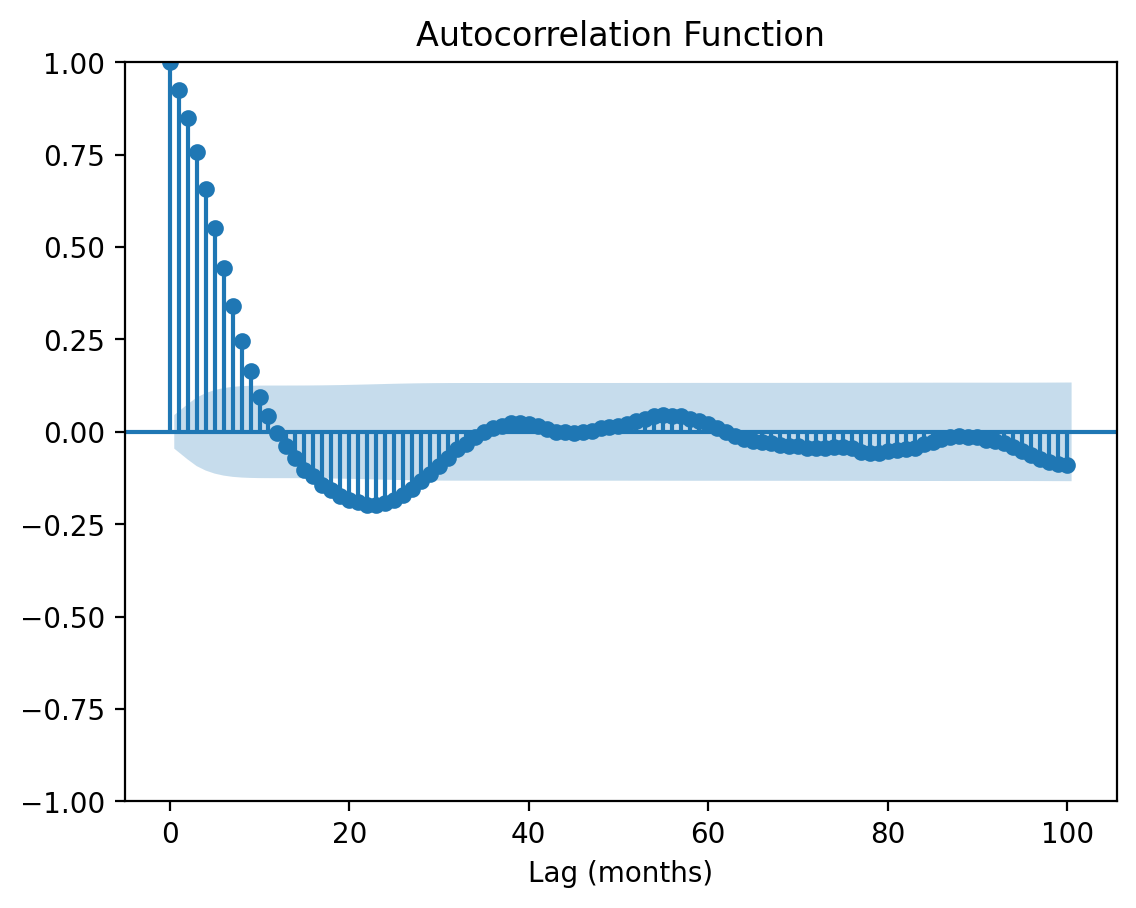

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plot_acf(df['NINA34'].dropna(), lags=100)
plt.xlabel('Lag (months)')
plt.title('Autocorrelation Function')

Dominant period: 2.87 years


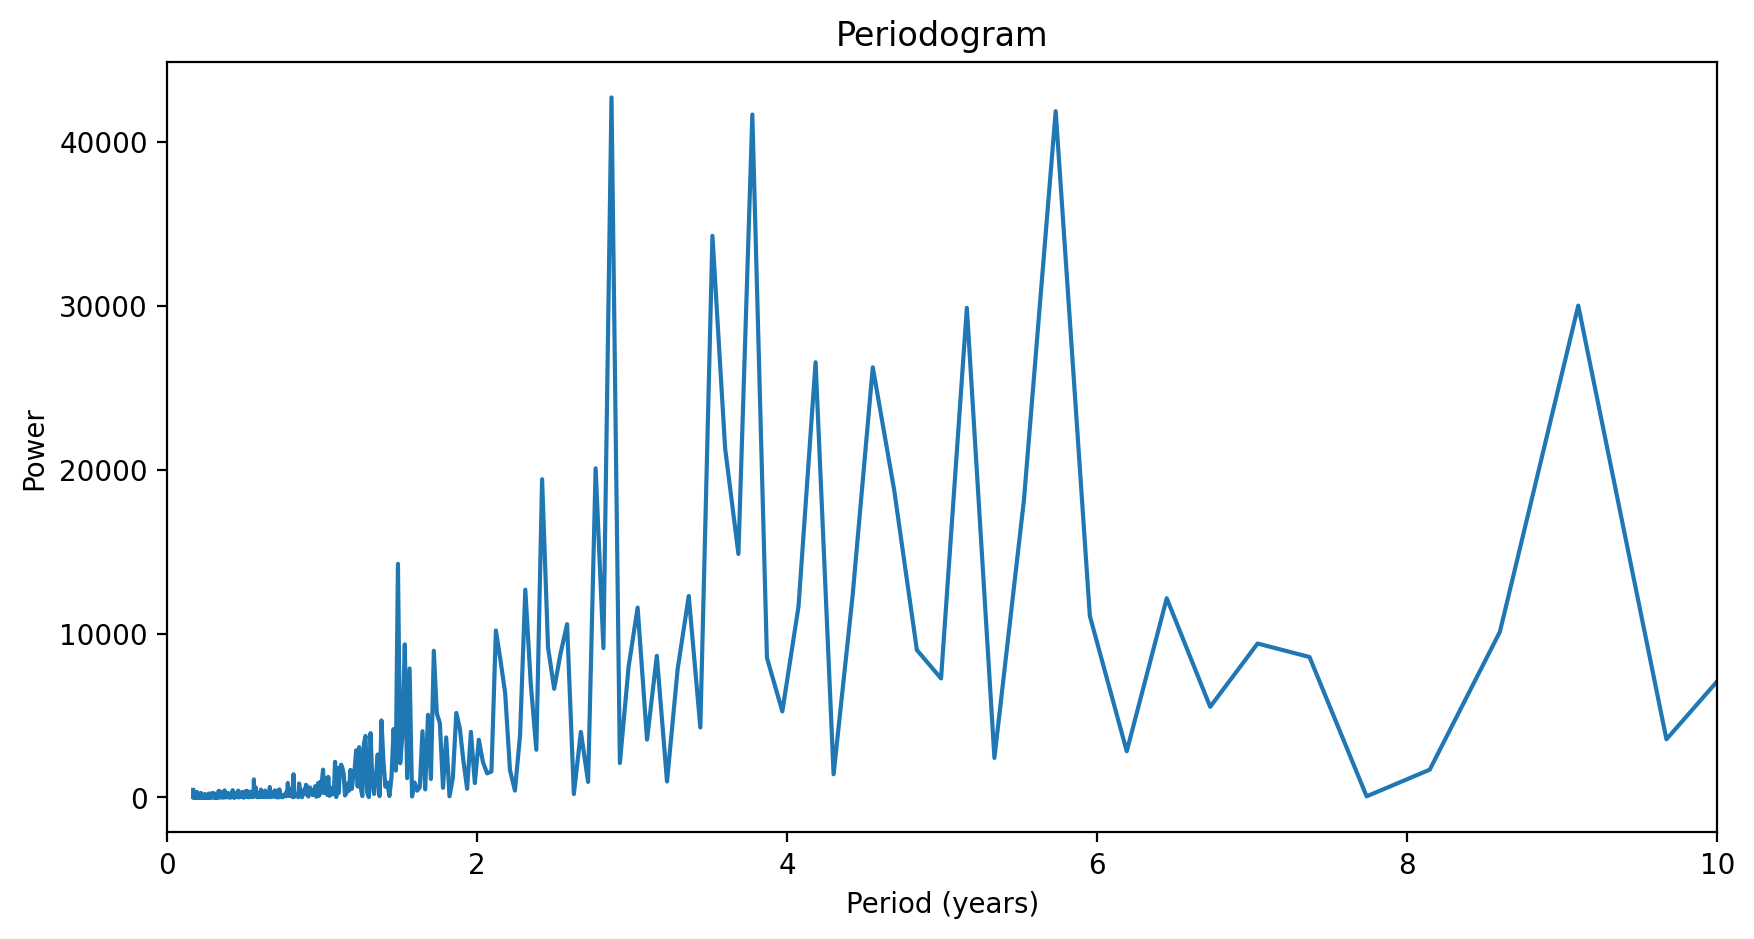

In [ ]:
from scipy.fft import fft, fftfreq

data = df['NINA34'].dropna().values
n = len(data)

# Compute FFT
fft_vals = fft(data)
fft_power = np.abs(fft_vals)**2

# Get frequencies
freqs = fftfreq(n, d=1/12)  # d = 1/12 for monthly data

# Only positive frequencies
pos_mask = freqs > 0
freqs = freqs[pos_mask]
fft_power = fft_power[pos_mask]

# Convert to periods
periods = 1 / freqs

# Plot
plt.figure(figsize=(10, 5))
plt.plot(periods, fft_power)
plt.xlabel('Period (years)')
plt.ylabel('Power')
plt.xlim(0, 10)
plt.title('Periodogram')

# Find peak
peak_idx = np.argmax(fft_power)
print(f"Dominant period: {periods[peak_idx]:.2f} years")

In [ ]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime("1870-08-01")
    t = (timelist - reference_time) / pd.Timedelta(365, "D")
    return np.asarray(t)
t = dates_to_idx(df.index)

y = df['NINA34_smoothed'].values
first_nina = y[0]
y_std = np.std(y)
y_n = (y - first_nina) / y_std

df = df.assign(t=t)
df = df.assign(y_n=y_n)

In [ ]:
t = df['t'].values[:, None]
y = df['y_n'].values

In [ ]:
with pm.Model() as model:
    # Quasi periodic
    n_per1 = pm.HalfCauchy('n_per1', beta=1.5, initval=0.5)
    l_per1 = pm.Gamma('l_per1', alpha=1, beta=2)
    period_1 = pm.Gamma('period_1', alpha=8, beta=2)
    l_exp = pm.Gamma('l_exp', alpha=2, beta=1)
    cov_per1 = n_per1**2 * pm.gp.cov.ExpQuad(1, l_exp) * pm.gp.cov.Periodic(1, period_1, l_per1)

    # noise model
    σ = pm.HalfNormal("σ", sigma=0.25, initval=0.1)
    n_noise = pm.HalfNormal('n_noise', sigma=0.5, initval=0.05)
    l_noise = pm.Gamma('l_noise', alpha=2, beta=4)
    cov_noise = n_noise**2 * pm.gp.cov.Matern32(1, l_noise)
    # The Gaussian process is a sum of these three components
    cov_total = cov_per1 + cov_noise

    gp = pm.gp.Marginal(cov_func=cov_total)

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=t, y=y, sigma=σ)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)

Output()

In [ ]:
# display the results, dont show transformed parameter values
sorted([name + ":" + str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['l_exp:10.456799712611891',
 'l_noise:0.6497673711471431',
 'l_per1:0.7614338955271639',
 'n_noise:1.0291516519122663',
 'n_per1:0.7236212716549859',
 'period_1:3.0117596886242852',
 'σ:0.04037936002483708']

In [ ]:
dates = pd.date_range(start="1870-01-01", end="08/01/2040", freq="30D")
tnew = dates_to_idx(dates)[:, None]

print("Sampling gp predictions ...")
with model:
    mu_pred, cov_pred = gp.predict(tnew, point=mp)

# draw samples, and rescale
n_samples = 5
samples = pm.draw(pm.MvNormal.dist(mu=mu_pred, cov=cov_pred), draws=n_samples)
samples = samples * y_std + first_nina

Sampling gp predictions ...


In [ ]:
# make plot
p = figure(x_axis_type="datetime", width=700, height=300)
p.yaxis.axis_label = "Nino 1.2"
p.xaxis.axis_label = "Date"

# plot mean and 2σ region of total prediction
# scale mean and var
mu_pred_sc = mu_pred * y_std + first_nina
sd_pred_sc = np.sqrt(np.diag(cov_pred) * y_std**2)

upper = mu_pred_sc + 2 * sd_pred_sc
lower = mu_pred_sc - 2 * sd_pred_sc
band_x = np.append(dates, dates[::-1])
band_y = np.append(lower, upper[::-1])

p.line(dates, mu_pred_sc, line_width=2, line_color="firebrick", legend_label="Total fit")
p.patch(band_x, band_y, color="firebrick", alpha=0.6, line_color="white")

# some predictions
idx = np.random.randint(0, samples.shape[0], 10)
p.multi_line(
    [dates] * len(idx),
    [samples[i, :] for i in idx],
    color="firebrick",
    alpha=0.5,
    line_width=0.5,
)

# true value
# p.circle(data_later.index, data_later["CO2"], color="black", legend_label="Observed data")
predline = Span(location=pd.to_datetime('2025-08-01'), dimension='height', line_color='red', line_dash='dashed', line_width=2)
p.add_layout(predline)
p.scatter(
    df.index,
    df["Date"],
    marker="circle",
    line_color="black",
    alpha=0.1,
    size=5,
    legend_label="Observed data",
)

p.legend.location = "bottom_right"
show(p)

In [ ]:
import seaborn
seaborn.load_dataset('flights')

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


In [ ]:
url = "https://www.sidc.be/SILSO/INFO/snmtotcsv.php"
df = pd.read_csv(url, sep=';', header=None,
                 names=['Year', 'Month', 'Date', 'Sunspot_Number', 'StdDev', 'Observations', 'Definitive'])
df.head()

,Year,Month,Date,Sunspot_Number,StdDev,Observations,Definitive
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [ ]:
df['Date'] = pd.to_datetime(df['Year'], format='%Y')
df.tail()

,Year,Month,Date,Sunspot_Number,StdDev,Observations,Definitive
3318,2025,7,2025-01-01,125.6,16.9,1145,0
3319,2025,8,2025-01-01,133.5,18.2,1114,0
3320,2025,9,2025-01-01,129.8,15.4,961,0
3321,2025,10,2025-01-01,114.6,17.5,827,0
3322,2025,11,2025-01-01,91.8,13.9,792,0


In [ ]:
p = figure(
    x_axis_type='datetime',
    title='Sunspot Index over time',
    width=800,
    height=500
)
p.yaxis.axis_label = 'Sunspot Number'
p.xaxis.axis_label = 'Date'

p.line(df['Year'], df['Sunspot_Number'], line_width=2, line_color='black', alpha=0.5)

show(p)

In [ ]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime

# Function to download tidal data
def get_tidal_data(station_id, start_date, end_date, product='water_level'):
    """
    Download tidal data from NOAA API

    Popular stations:
    - 8443970: Boston, MA
    - 9414290: San Francisco, CA
    - 8518750: New York, NY
    - 8720030: Pensacola, FL
    """
    base_url = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"

    params = {
        'station': station_id,
        'product': product,
        'begin_date': start_date,
        'end_date': end_date,
        'datum': 'MLLW',  # Mean Lower Low Water
        'units': 'metric',
        'time_zone': 'gmt',
        'format': 'json',
        'application': 'research'
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        if 'data' in data:
            df = pd.DataFrame(data['data'])
            df['t'] = pd.to_datetime(df['t'])
            df['v'] = pd.to_numeric(df['v'], errors='coerce')
            return df
        else:
            print(f"Error: {data.get('error', 'Unknown error')}")
            return None
    else:
        print(f"HTTP Error: {response.status_code}")
        return None

# Download 1 month of data (for starter)
# Format: YYYYMMDD
df = get_tidal_data(
    station_id='8443970',  # Boston Harbor
    start_date='20240101',
    end_date='20240131',
    product='water_level'
)

# Rename columns
df.columns = ['time', 'water_level', 'sigma', 'flags', 'quality']
df = df[['time', 'water_level']].dropna()

print(f"Downloaded {len(df)} observations")
print(f"Time range: {df['time'].min()} to {df['time'].max()}")
df.head()

Downloaded 7440 observations
Time range: 2024-01-01 00:00:00 to 2024-01-31 23:54:00


,time,water_level
0,2024-01-01 00:00:00,0.782
1,2024-01-01 00:06:00,0.739
2,2024-01-01 00:12:00,0.690
3,2024-01-01 00:18:00,0.641
4,2024-01-01 00:24:00,0.588


In [ ]:
df_sub = df.iloc[::10].copy()
t = df_sub['t'].values[:, None]
y = df_sub['y_n'].values

print(f"Reduced from {len(df)} to {len(df_sub)} points")

Reduced from 7440 to 744 points


In [ ]:
p = figure(
    x_axis_type='datetime',
    title='Water Level over time',
    width=800,
    height=500
)
p.yaxis.axis_label = 'Water Level'
p.xaxis.axis_label = 'Date'

p.line(df_sub['time'], df_sub['water_level'], line_width=2, line_color='black', alpha=0.5)

show(p)

In [ ]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime("2024-01-01")
    t = (timelist - reference_time) / pd.Timedelta(0.01, "D")
    return np.asarray(t)
t = dates_to_idx(df['time'])

y = df['water_level'].values
first_water = y[0]
y_std = np.std(y)
y_n = (y - first_water) / y_std

df = df.assign(t=t)
df = df.assign(y_n=y_n)

In [ ]:
t = df['t'].values[:, None]
y = df['y_n'].values

In [ ]:
with pm.Model() as model:
    # periodic
    n_per1 = pm.HalfCauchy('n_per1', beta=1.5, initval=0.5)
    l_per1 = pm.Gamma('l_per1', alpha=1, beta=2)
    period_1 = pm.Normal('period_1', mu=51.7, sigma=2.0)
    cov_per1 = n_per1**2 * pm.gp.cov.Periodic(1, period_1, l_per1)

    # noise model
    σ = pm.HalfNormal("σ", sigma=0.25, initval=0.1)
    n_noise = pm.HalfNormal('n_noise', sigma=0.5, initval=0.05)
    l_noise = pm.Gamma('l_noise', alpha=2, beta=10)
    cov_noise = n_noise**2 * pm.gp.cov.Matern32(1, l_noise)
    # The Gaussian process is a sum of these three components
    cov_total = cov_per1 + cov_noise

    gp = pm.gp.Marginal(cov_func=cov_total)

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=t, y=y, sigma=σ)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)

Output()

In [ ]:
with pm.Model() as model:
    # Semi-diurnal tide (~12.4 hours = 51.7 units in your time scale)
    n_per1 = pm.HalfCauchy('n_per1', beta=1.5, initval=0.5)
    l_per1 = pm.Gamma('l_per1', alpha=2, beta=1)
    period_1 = pm.Normal('period_1', mu=51.7, sigma=2.0)  # ✅ Fixed!
    cov_per1 = n_per1**2 * pm.gp.cov.Periodic(1, period_1, l_per1)

    # Spring-neap modulation (~14.7 days = 1470 units)
    n_per2 = pm.HalfCauchy('n_per2', beta=0.5, initval=0.2)
    l_per2 = pm.Gamma('l_per2', alpha=2, beta=1)
    period_2 = pm.Normal('period_2', mu=1470, sigma=50)  # ✅ Added!
    cov_per2 = n_per2**2 * pm.gp.cov.Periodic(1, period_2, l_per2)

    # Short-term noise
    σ = pm.HalfNormal("σ", sigma=0.25, initval=0.1)

    # Total covariance
    cov_total = cov_per1 + cov_per2
    gp = pm.gp.Marginal(cov_func=cov_total)

    y_ = gp.marginal_likelihood("y", X=t, y=y, sigma=σ)

    mp = pm.find_MAP(include_transformed=True)

Output()

In [ ]:
# make plot
p = figure(x_axis_type="datetime", width=700, height=300)
p.yaxis.axis_label = "Water Level"
p.xaxis.axis_label = "Date"

# plot mean and 2σ region of total prediction
# scale mean and var
mu_pred_sc = mu_pred * y_std + first_water
sd_pred_sc = np.sqrt(np.diag(cov_pred) * y_std**2)

upper = mu_pred_sc + 2 * sd_pred_sc
lower = mu_pred_sc - 2 * sd_pred_sc
band_x = np.append(dates, dates[::-1])
band_y = np.append(lower, upper[::-1])

p.line(dates, mu_pred_sc, line_width=2, line_color="firebrick", legend_label="Total fit")
p.patch(band_x, band_y, color="firebrick", alpha=0.6, line_color="white")

# some predictions
idx = np.random.randint(0, samples.shape[0], 10)
p.multi_line(
    [dates] * len(idx),
    [samples[i, :] for i in idx],
    color="firebrick",
    alpha=0.5,
    line_width=0.5,
)

# true value
# p.circle(data_later.index, data_later["CO2"], color="black", legend_label="Observed data")
predline = Span(location=pd.to_datetime('2025-08-01'), dimension='height', line_color='red', line_dash='dashed', line_width=2)
p.add_layout(predline)
p.line(
    df['time'],
    df["water_level"],
    line_color="black",
    alpha=0.1,
    size=5,
    legend_label="Observed data",
)

p.legend.location = "bottom_right"
show(p)

AttributeError: unexpected attribute 'size' to Line, possible attributes are decorations, js_event_callbacks, js_property_callbacks, line_alpha, line_cap, line_color, line_dash, line_dash_offset, line_join, line_width, name, subscribed_events, syncable, tags, x or y

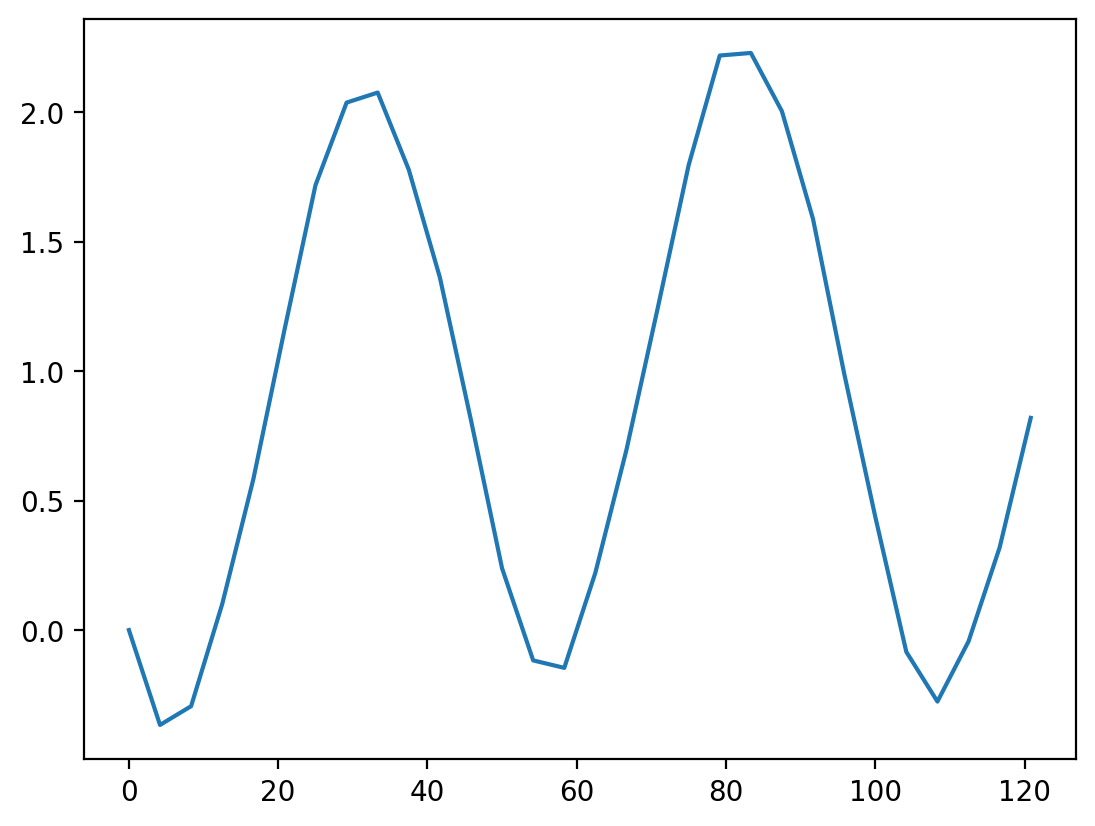

In [ ]:
import matplotlib.pyplot as plt

plt.plot(t[:30], y[:30])

In [ ]:
# display the results, dont show transformed parameter values
sorted([name + ":" + str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['l_noise:0.10000803406212927',
 'l_per1:1.1999862579725118',
 'l_per2:0.032032246708909126',
 'n_noise:6.919227839106122e-06',
 'n_per1:1.4580758307119137',
 'n_per2:0.3538057914627467',
 'period_1:51.863764086987395',
 'period_2:1491.5743371893334',
 'σ:0.21511281349101133']

In [ ]:
dates = pd.date_range(start="2024-01-01", end="2024-03-30", freq="1H")
tnew = dates_to_idx(dates)[:, None]

print("Sampling gp predictions ...")
with model:
    mu_pred, cov_pred = gp.predict(tnew, point=mp)

# draw samples, and rescale
n_samples = 10
samples = pm.draw(pm.MvNormal.dist(mu=mu_pred, cov=cov_pred), draws=n_samples)
samples = samples * y_std + first_water

Sampling gp predictions ...


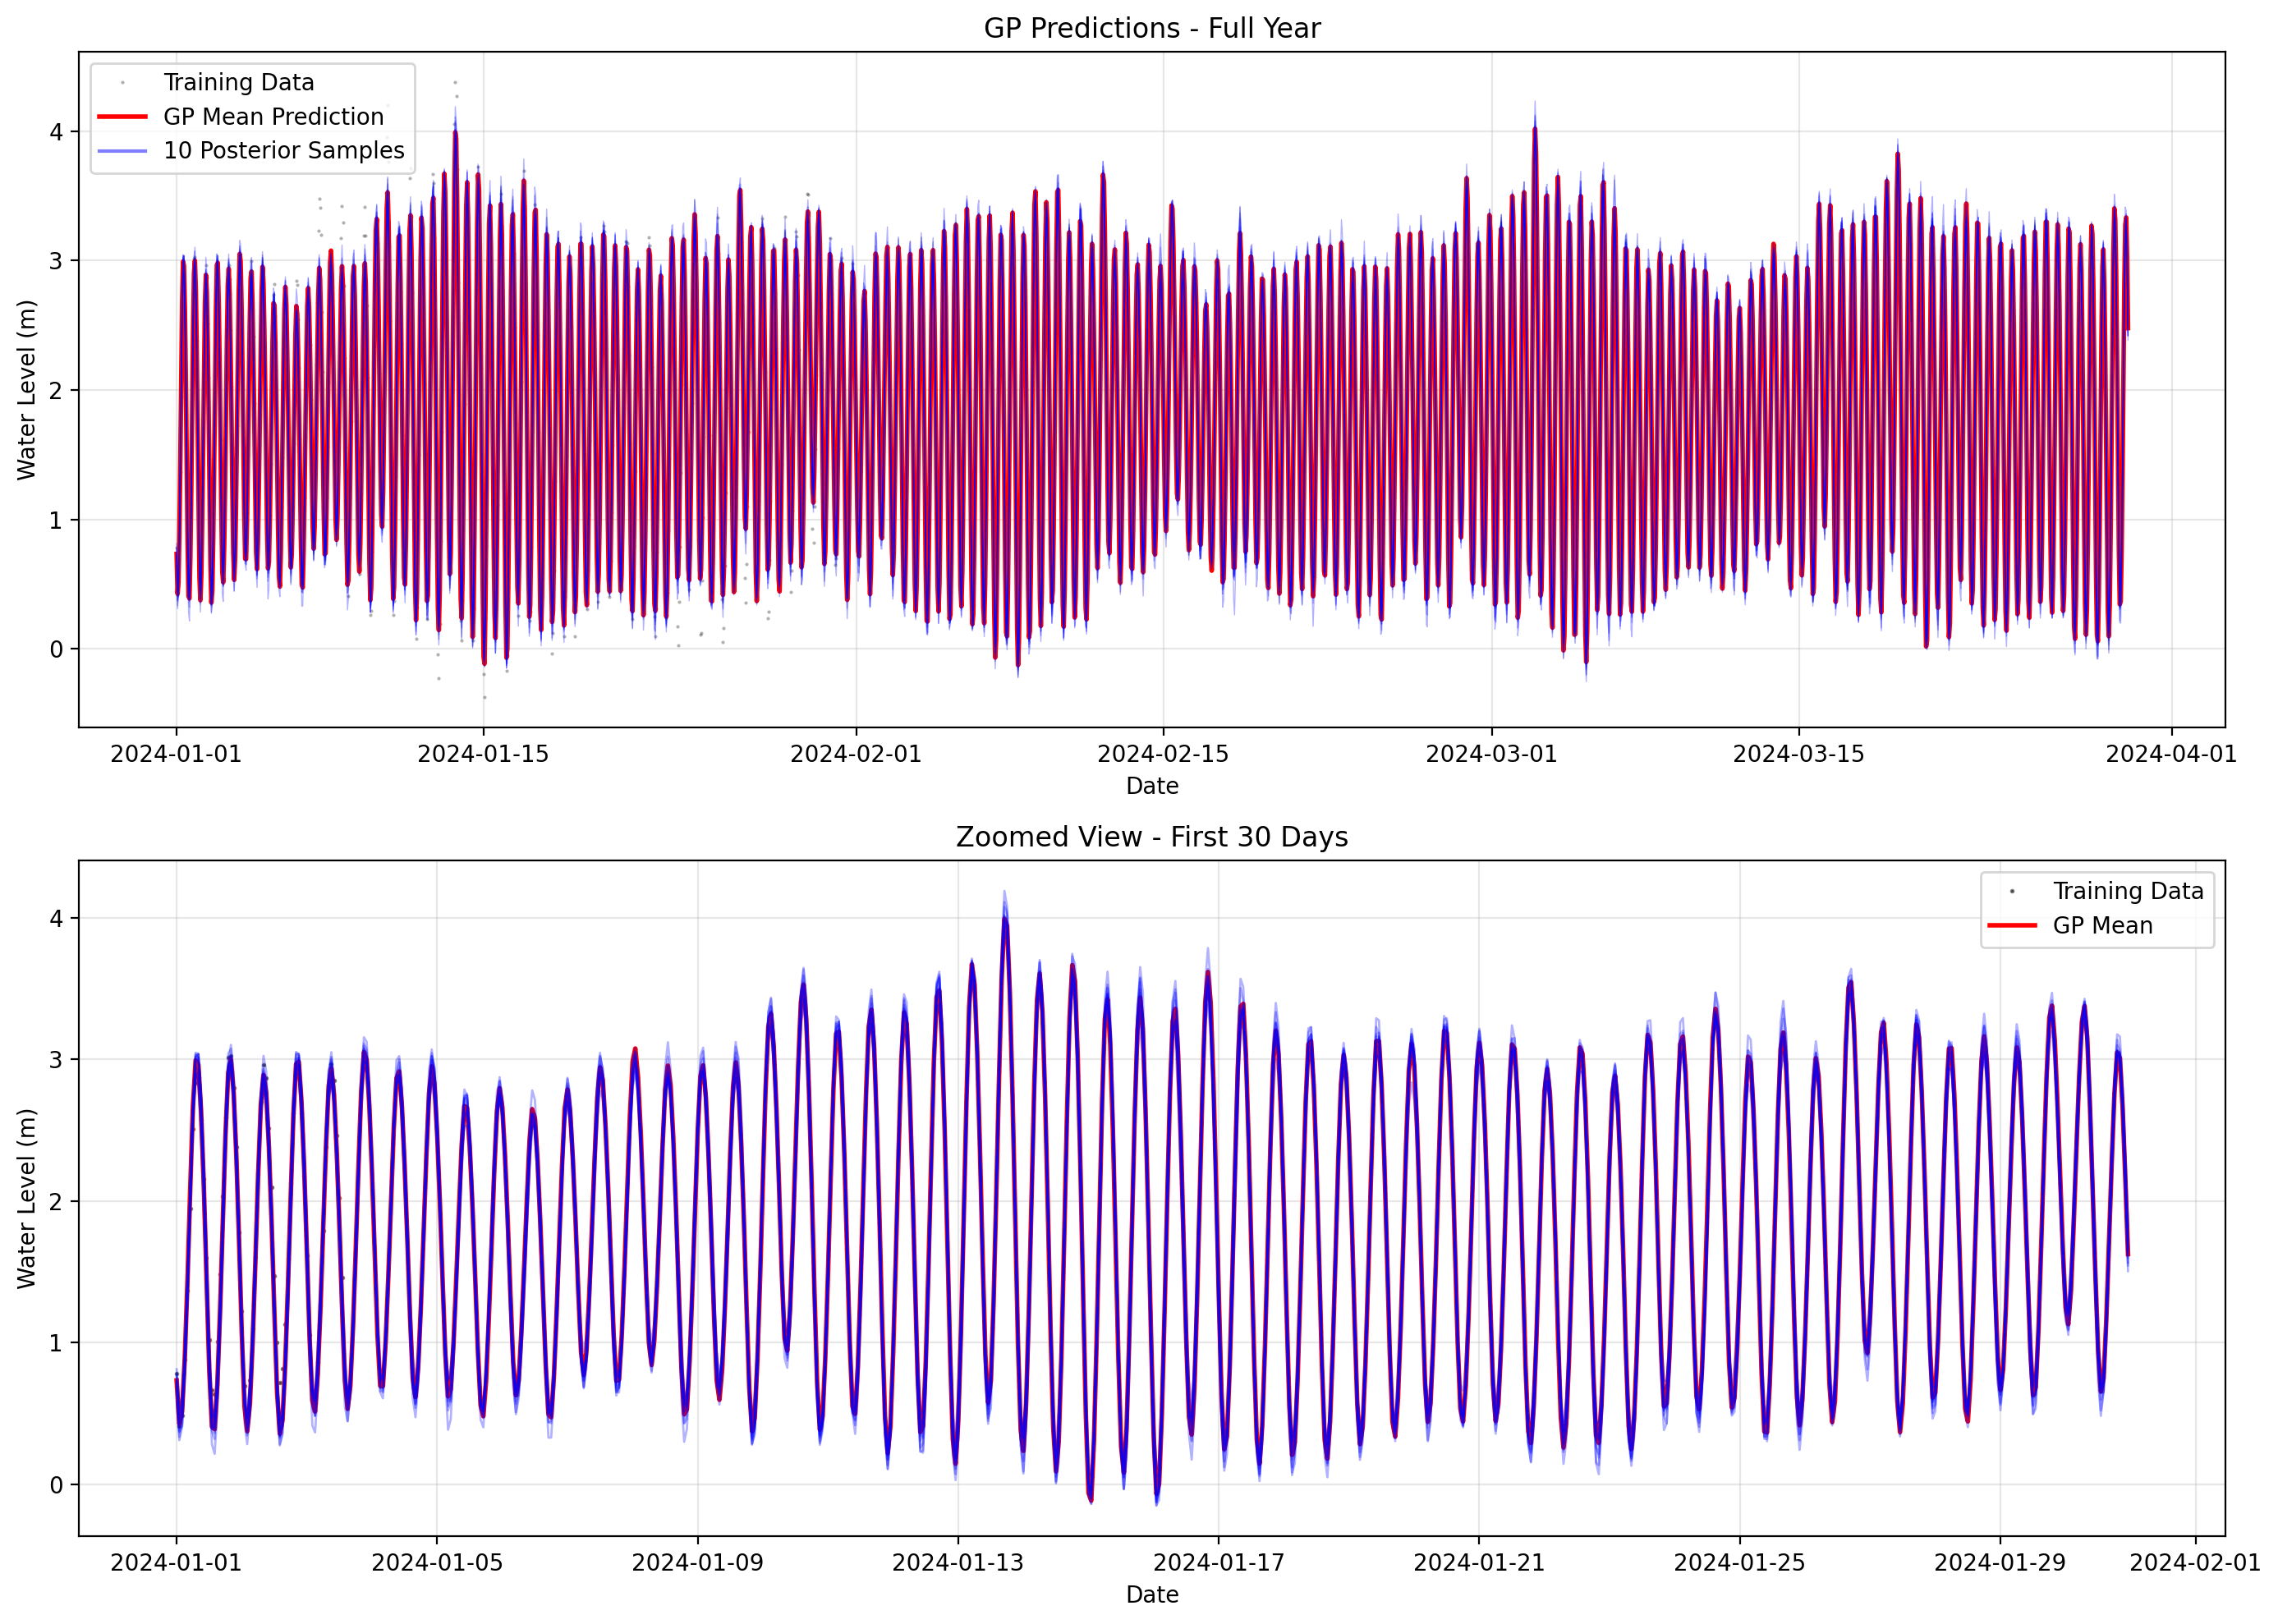

In [ ]:
import matplotlib.pyplot as plt

mu_pred_rescaled = mu_pred * y_std + first_water
y_original = y * y_std + first_water

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(df_sub['time'], y_original, 'k.', alpha=0.3, markersize=1, label='Training Data')
ax1.plot(dates, mu_pred_rescaled, 'r-', linewidth=2, label='GP Mean Prediction')


for i in range(n_samples):
    ax1.plot(dates, samples[i, :], 'b-', alpha=0.3, linewidth=0.5)
ax1.plot([], [], 'b-', alpha=0.5, label=f'{n_samples} Posterior Samples')

ax1.set_xlabel('Date')
ax1.set_ylabel('Water Level (m)')
ax1.set_title('GP Predictions - Full Year')
ax1.legend()
ax1.grid(True, alpha=0.3)
zoom_days = 30  # First 30 days
zoom_mask = dates < dates[0] + pd.Timedelta(days=zoom_days)

ax2.plot(df_sub['time'][:len(y_original)//12], y_original[:len(y_original)//12],
         'k.', alpha=0.5, markersize=2, label='Training Data')
ax2.plot(dates[zoom_mask], mu_pred_rescaled[zoom_mask], 'r-', linewidth=2,
         label='GP Mean')

for i in range(n_samples):
    ax2.plot(dates[zoom_mask], samples[i, zoom_mask], 'b-', alpha=0.3, linewidth=1)

ax2.set_xlabel('Date')
ax2.set_ylabel('Water Level (m)')
ax2.set_title(f'Zoomed View - First {zoom_days} Days')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

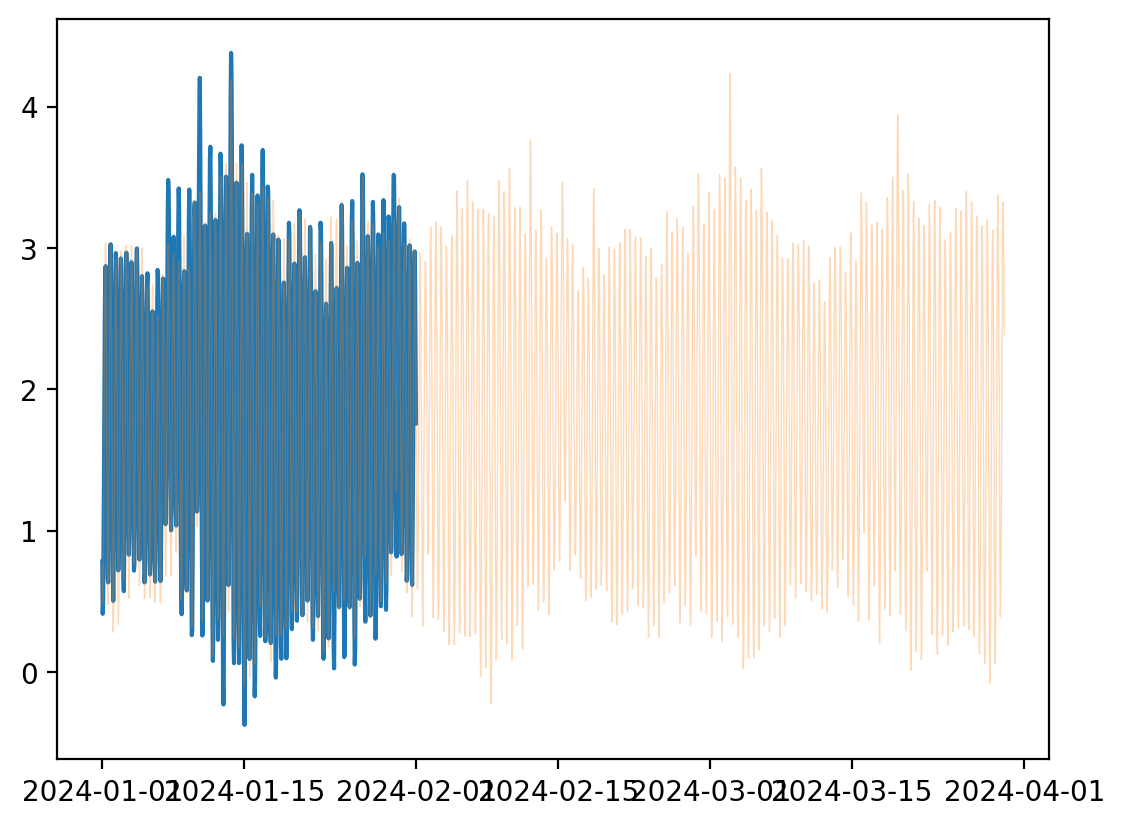

In [ ]:
plt.plot(df_sub['time'], df_sub['water_level'])
plt.plot(dates, samples[0, :], alpha=0.3, linewidth=0.5)

In [ ]:
df

,time,water_level,t,y_n
0,2024-01-01 00:00:00,0.782,0.000000,0.000000
1,2024-01-01 00:06:00,0.739,0.416667,-0.042700
2,2024-01-01 00:12:00,0.690,0.833333,-0.091359
3,2024-01-01 00:18:00,0.641,1.250000,-0.140018
4,2024-01-01 00:24:00,0.588,1.666667,-0.192649
...,...,...,...,...
7435,2024-01-31 23:30:00,1.471,3097.916667,0.684201
7436,2024-01-31 23:36:00,1.415,3098.333333,0.628591
7437,2024-01-31 23:42:00,1.359,3098.750000,0.572981
7438,2024-01-31 23:48:00,1.294,3099.166667,0.508434


In [73]:
def load_noaa_index(index_name):
  if index_name.startswith('nino'):
    url = f"https://psl.noaa.gov/data/timeseries/month/data/{index_name}.long.anom.data"
  else:
    url = f"https://psl.noaa.gov/data/correlation/{index_name}.data"
  df = pd.read_csv(url, delim_whitespace=True, header=None, skiprows=1)
  years = df.iloc[:, 0].values
  monthly_data = df.iloc[:, 1:13].values.flatten()

  dates = pd.date_range(start=f'{int(years[0])}-01-01',
                        periods=len(monthly_data), freq='MS')
  result = pd.DataFrame({
      'date': dates,
      'value': monthly_data
  })
  result['value'] = pd.to_numeric(result['value'], errors='coerce')
  result = result[(result['value'] != '-99.99') & (result['value'] != -99.99)]
  result = result.dropna()
  return result
base_url = "https://psl.noaa.gov/data/correlation/"
nino34 = load_noaa_index("nino34")
nino12 = load_noaa_index('nino12')
nino3 = load_noaa_index('nino3')
nino4 = load_noaa_index('nino4')
soi = load_noaa_index('soi')

In [94]:
df_new = pd.merge(nino3, soi, on='date')
df_new.columns = ['date', 'nino3', 'soi']
df_new.corr()

,date,nino3,soi
date,1.000000,0.111032,0.018606
nino3,0.111032,1.000000,-0.651475
soi,0.018606,-0.651475,1.000000


In [95]:
df_new = pd.merge(df_new, nino4)
df_new.columns = ['date', 'nino3', 'soi', 'nino4']
df_new = pd.merge(df_new, nino34)
df_new.columns = ['date', 'nino3', 'soi', 'nino4', 'nino34']
df_new = pd.merge(df_new, nino12)
df_new.columns = ['date', 'nino3', 'soi', 'nino4', 'nino34', 'nino12']
df_new

,date,nino3,soi,nino4,nino34,nino12
0,1951-01-01,-0.72,2.5,-1.26,-1.13,0.14
1,1951-02-01,-0.43,1.5,-0.96,-0.74,-0.56
2,1951-03-01,-0.63,-0.2,-0.77,-0.77,-0.22
3,1951-04-01,0.00,-0.5,-0.53,-0.17,0.30
4,1951-05-01,-0.12,-1.1,-0.19,-0.10,0.75
...,...,...,...,...,...,...
891,2025-04-01,0.05,0.9,-0.09,-0.08,0.04
892,2025-05-01,-0.12,0.7,0.02,-0.08,0.21
893,2025-06-01,0.03,0.5,0.14,0.01,0.44
894,2025-07-01,0.07,1.0,0.05,-0.03,0.29


In [97]:
df_new.corr()

,date,nino3,soi,nino4,nino34,nino12
date,1.000000,0.111032,0.018606,0.210109,0.073588,0.030193
nino3,0.111032,1.000000,-0.651475,0.773393,0.945166,0.845938
soi,0.018606,-0.651475,1.000000,-0.685310,-0.720446,-0.476883
nino4,0.210109,0.773393,-0.685310,1.000000,0.908408,0.484454
nino34,0.073588,0.945166,-0.720446,0.908408,1.000000,0.684243
nino12,0.030193,0.845938,-0.476883,0.484454,0.684243,1.000000


In [145]:
from sklearn.preprocessing import StandardScaler

t = (df_new['date'] - df_new['date'].min()).dt.days / 365.0

X = np.column_stack([
    t[:700],
    df_new['soi'].values[:700]
])
y = df_new['nino34'].values[:700]
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [146]:
with pm.Model() as model:
  l = pm.Gamma('l', alpha=2, beta=1, shape=2)
  cov_ard = pm.gp.cov.ExpQuad(2, ls=l)

  period = pm.Gamma('period', alpha=8, beta=2, initval=3.5)
  l_per = pm.Gamma('l_per', alpha=2, beta=1)
  cov_per = pm.gp.cov.Periodic(2, period, ls=l_per, active_dims=[0])

  n = pm.HalfCauchy('n', beta=2)
  cov_total = n**2 * (cov_per + cov_ard)

  sigma = pm.HalfNormal('sigma', sigma=0.5)

  gp = pm.gp.Marginal(cov_func=cov_total)
  y_ = gp.marginal_likelihood('y', X=X_scaled, y=y_scaled, sigma=sigma)
  mp = pm.find_MAP(include_transformed=True)

Output()

In [147]:
dates = pd.date_range(start="1951-01-01", end="2024-08-01", freq="1MS")
tnew = (dates - pd.Timestamp("1951-01-01")).days.values / 365.0
sois = df_new['soi'].values

X_test = np.column_stack([
    t[600:],
    sois[600:]
])

X_test_scaled = scaler_x.transform(X_test)

print(f"X_test shape: {X_test_scaled.shape}")

print("Sampling gp predictions ...")
with model:
    mu_pred, cov_pred = gp.predict(X_test_scaled, point=mp)

n_samples = 10
samples = pm.draw(pm.MvNormal.dist(mu=mu_pred, cov=cov_pred), draws=n_samples)

mu_pred_rescaled = scaler_y.inverse_transform(mu_pred.reshape(-1, 1)).flatten()
samples_rescaled = scaler_y.inverse_transform(samples.T).T

print(f"Predictions shape: {mu_pred_rescaled.shape}")

X_test shape: (296, 2)
Sampling gp predictions ...
Predictions shape: (296,)


In [137]:
len(df_new['soi'].values)

896

In [138]:
len(tnew)

884

In [155]:
t_test = t[600:]
y_test = df_new['nino34'].values[600:]
soi_test = df_new['soi'].values[600:]

X_test = np.column_stack([
    t_test,
    soi_test
])

X_test_scaled = scaler_x.transform(X_test)
with model:
    mu_pred, cov_pred = gp.predict(X_test_scaled, point=mp)

n_samples = 10
samples = pm.draw(pm.MvNormal.dist(mu=mu_pred, cov=cov_pred), draws=n_samples)
samples_rescaled = scaler_y.inverse_transform(samples.T).T
mean_pred = samples_rescaled.mean(axis=0)
std_pred = samples_rescaled.std(axis=0)

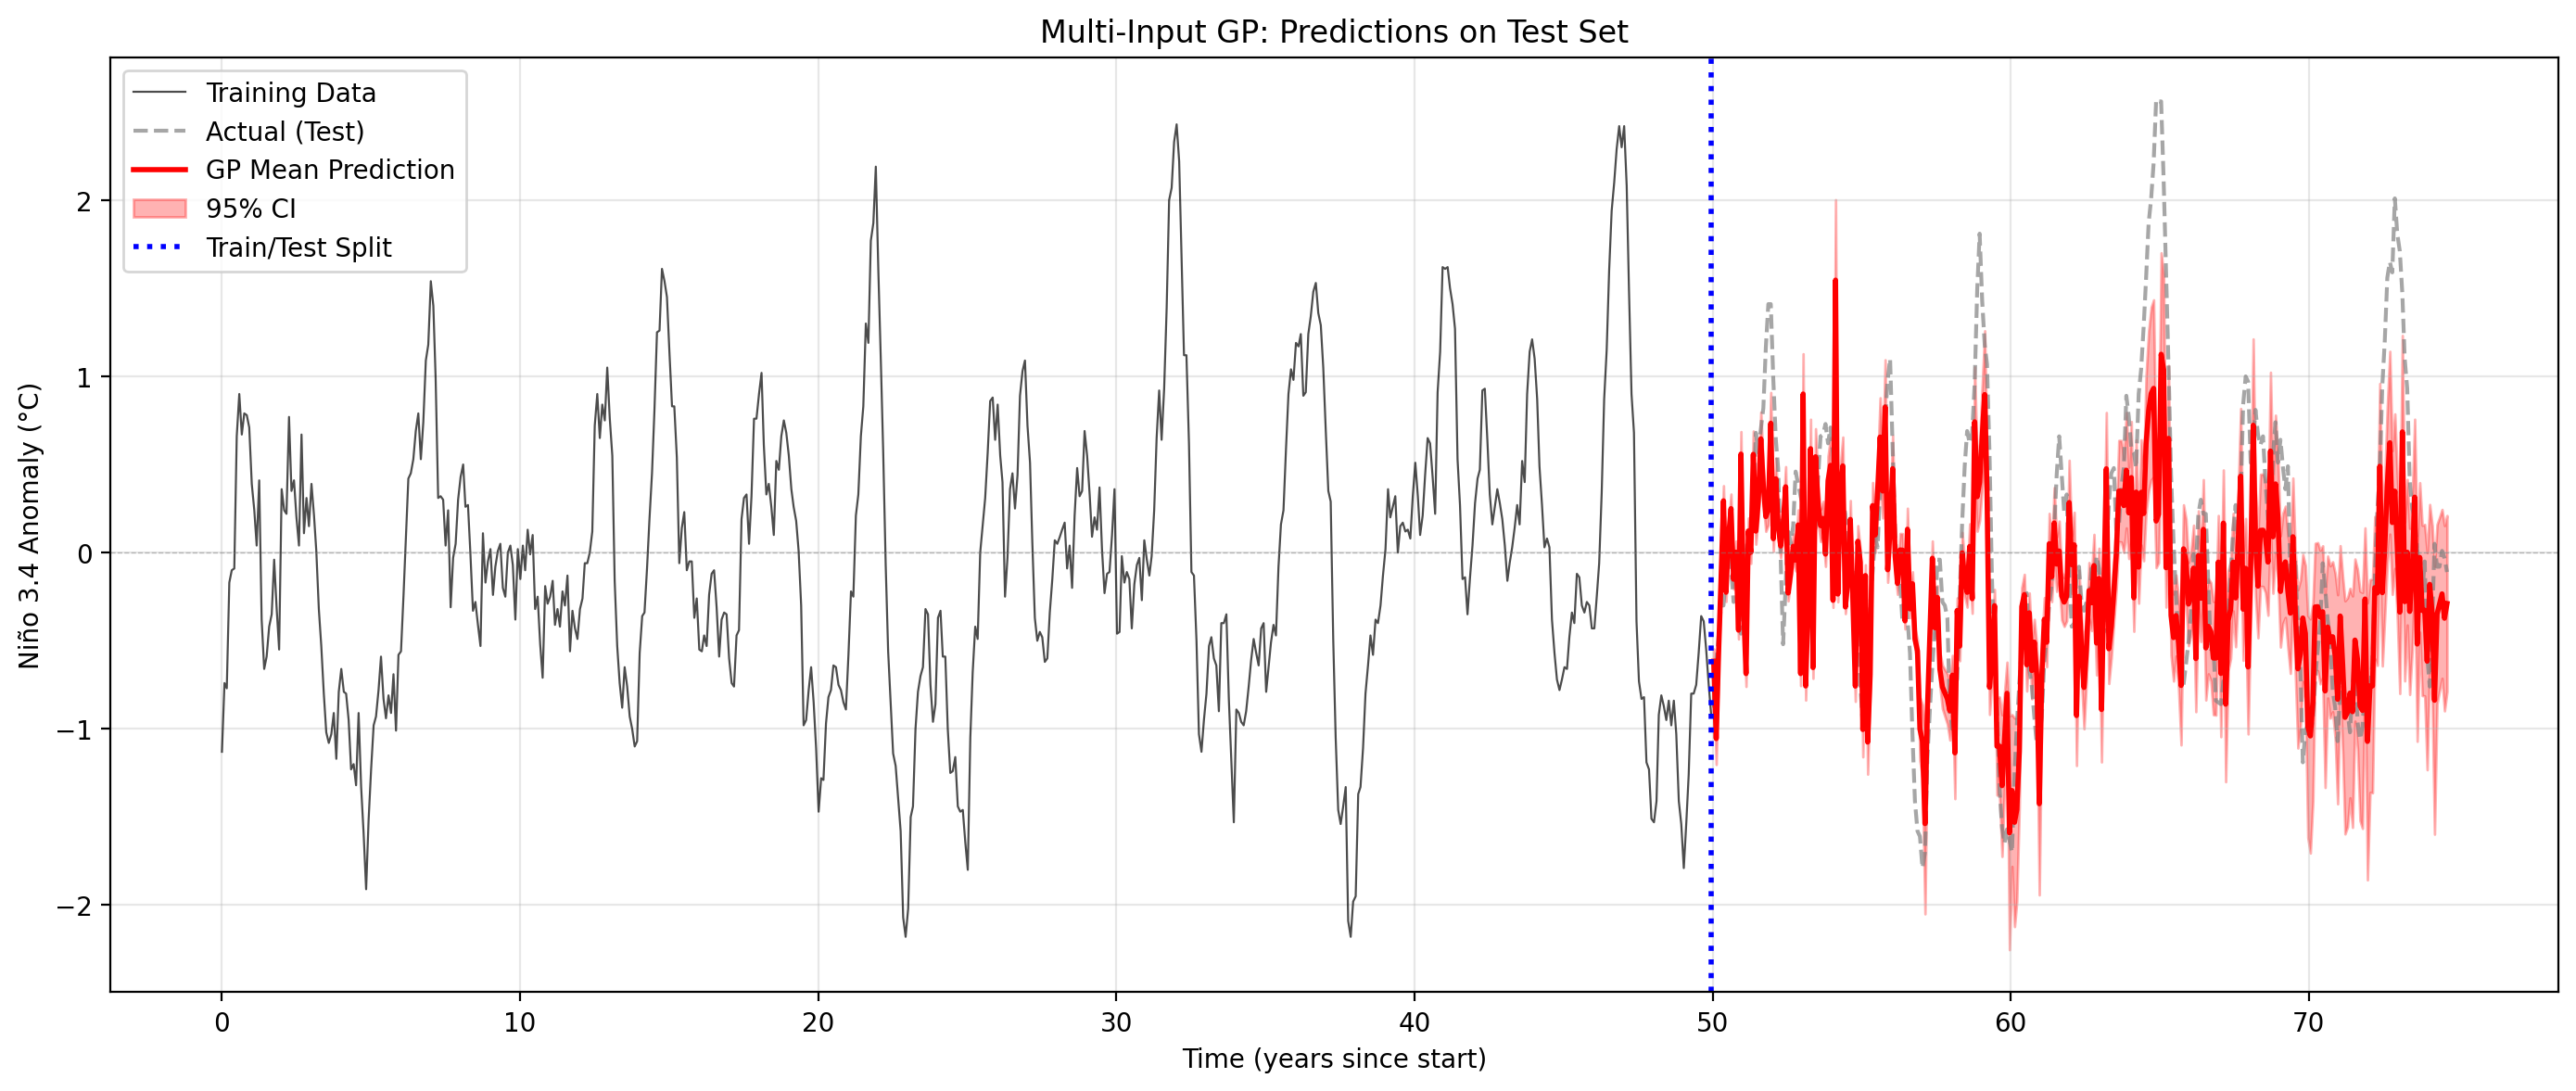

In [157]:
import matplotlib.pyplot as plt
t_train = t[:600]
y_train = df_new['nino34'].values[:600]

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(t_train, y_train, 'k-', alpha=0.7, linewidth=0.8, label='Training Data')

ax.plot(t_test, y_test, 'gray', alpha=0.7, linewidth=1.5, label='Actual (Test)', linestyle='--')

ax.plot(t_test, mean_pred, 'r-', linewidth=2, label='GP Mean Prediction')

ax.fill_between(
    t_test,
    mean_pred - 2*std_pred,
    mean_pred + 2*std_pred,
    alpha=0.3,
    color='red',
    label='95% CI'
)
ax.axvline(x=t_train.iloc[-1], color='blue', linestyle=':', linewidth=2, label='Train/Test Split')

ax.set_xlabel('Time (years since start)')
ax.set_ylabel('Niño 3.4 Anomaly (°C)')
ax.set_title('Multi-Input GP: Predictions on Test Set')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

In [72]:
import requests

url = "https://psl.noaa.gov/data/timeseries/month/data/soi.long.data"
response = requests.get(url)

# Print first 30 lines
# print("First 30 lines of the file:")
# print("="*60)
# for i, line in enumerate(response.text.split('\n')[:30]):
#     print(f"{i:3d}: {line}")

df = pd.read_csv(url, delim_whitespace=True, header=None, skiprows=[1, -1])

ParserError: Error tokenizing data. C error: Expected 2 fields in line 3, saw 13


In [69]:
import requests

url = "https://psl.noaa.gov/data/timeseries/month/data/nino34.long.anom.data"
response = requests.get(url)

# Print first 30 lines
print("First 30 lines of the file:")
print("="*60)
for i, line in enumerate(response.text.split('\n')[:30]):
    print(f"{i:3d}: {line}")

First 30 lines of the file:
  0:           1870        2025
  1:  1870    -1.00   -1.20   -0.83   -0.81   -1.27   -1.08   -1.04   -0.88   -0.53   -0.92   -0.79   -0.79
  2:  1871    -0.25   -0.58   -0.43   -0.50   -0.71   -0.53   -0.60   -0.33   -0.24   -0.33   -0.31   -0.58
  3:  1872    -0.72   -0.62   -0.50   -0.77   -0.62   -0.52   -0.32   -0.85   -1.02   -0.94   -0.79   -0.88
  4:  1873    -0.78   -1.01   -1.31   -0.67   -0.53   -0.48   -0.58   -0.39   -0.34   -0.78   -0.77   -0.70
  5:  1874    -0.93   -1.06   -1.40   -0.94   -0.86   -0.72   -1.00   -1.05   -1.13   -1.25   -1.33   -1.14
  6:  1875    -0.71   -0.37   -0.59   -0.87   -1.09   -0.76   -0.85   -0.81   -0.91   -0.83   -0.64   -0.75
  7:  1876    -0.95   -1.20   -1.13   -1.18   -1.08   -0.43   -0.34   -0.16   -0.02    0.11    0.15    0.23
  8:  1877     0.35    0.46    0.52    0.50    0.76    0.98    1.42    1.54    1.75    1.95    2.08    2.49
  9:  1878     2.41    2.43    1.31    0.92    0.82    0.92    0.25   -0.11 